## Load the data

First of all, let's load the dataset into a dataframe with the **pandas** package.

In [1]:
# Set warnings to "ignore" to keep the notebook clean
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import the packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import nltk
import jinja2
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/timtamothy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/timtamothy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Create the filepath for csv file
import os
parent_folder = os.path.dirname(os.path.abspath(os.getcwd()))
file=os.path.join(parent_folder, '2. Raw Data/Mandarin_to_English.csv')

In [4]:
# Read the csv file
df=pd.read_csv(file)

## Data Preprocessing

### Initial data exploration

Once the data is loaded and saved into a dataframe, we perform the initial data exploration such as displaying the first few rows, checking the missing values with the summary.

In [5]:
# display first 5 rows
df.head()

,original,corrected
0,about my speech,Uncorrected
1,yesterday i was told that i would be doing a p...,Uncorrected
2,"every indiviual is infact very detached,imacap...",Uncorrected
3,"i m unnerved and now feeling exhausted , what ...",Uncorrected
4,Treaty of Versailles did the big three achieve...,Uncorrected


In [6]:
# display the last 5 rows with wider column width
# credit: https://stackoverflow.com/questions/39680147/can-i-set-variable-column-widths-in-pandas
# df.tail().style.set_properties(subset=['original','corrected'], **{'width': '400px'})

In [7]:
# display the column summary.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384332 entries, 0 to 384331
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   original   384306 non-null  object
 1   corrected  384332 non-null  object
dtypes: object(2)
memory usage: 5.9+ MB


In [8]:
# display the missing values in columns
df.isna().sum()

original     26
corrected     0
dtype: int64

In [9]:
# drop the rows with missing values
df.dropna(subset=['original'],inplace=True)

In [10]:
# check the missing values again
df.isna().sum()

original     0
corrected    0
dtype: int64

In [11]:
# display the number of sentences labelled as 'uncorrected'
df[df['corrected']=='Uncorrected'].count()

original     244785
corrected    244785
dtype: int64

In [12]:
# display the number of sentences labelled as 'uncorrected'
df[df['corrected']!='Uncorrected'].count()

original     139521
corrected    139521
dtype: int64

In [13]:
# filter out the 'uncorrected' sentences and save into new dataframe 'df_cor'
df_cor=df[df['corrected']!='Uncorrected'].reset_index(drop=True)

In [14]:
# remove the rows where are not strings if any
df_cor= df_cor[df_cor[["original", "corrected"]].applymap(lambda x: isinstance(x, str)).all(axis=1)]

In [15]:
# display the shape of dataframe
df_cor.shape

(139521, 2)

In [16]:
# remove the non-English characters
import re
df_cor["original"] = df_cor["original"].apply(lambda x: re.sub(r"[^a-zA-Z0-9\s.,!?'\-\(\)\[\]…]+", "", x) if isinstance(x, str) else x)
df_cor["corrected"] = df_cor["corrected"].apply(lambda x: re.sub(r"[^a-zA-Z0-9\s.,!?'\-\(\)\[\]…]+", "", x) if isinstance(x, str) else x)

In [17]:
# display the first 30 rows
df_cor.head(30).style.set_properties(subset=['original','corrected'], **{'width': '400px'})

,original,corrected
0,"There is a big difference between the east and the west, when comes to education,i always admired how the westerner educate their posterity,their method is so gentle and kind,full of love and meaning,whereas the asian method is rather more of violence,for example the chinese people believe that a child should be educated with rods!","There is a big difference between the east and the west, when comes to education. I always admired how the westerners educate their posterity, their method is so gentle and kind, full of love and meaning, whereas the Asian method is more violent, for example the Chinese people believe that a child should be educated with rods!"
1,"countless beating from their parent is believe to be capable of forging a successful child!thats how i was brought up at least, my parent always tell me how much they love me although they served me with rod every time i commit a wrongdoing,however when comes to the western way of parenting,it sounds like a fairy tale to me,for example the western parent always said this to their child if they happened to be repudiate, the parent will say this go to your room! this is something that will never happen in an asian family.","Countless beatings from their parent is believed to be capable of forging a successful child! That's how I was brought up at least. My parent always tell me how much they love me, although they served me with rod every time I committed a wrong doing. However, when comes to the western way of parenting, it sounds like a fairy tale to me. For example, the western parents always said this to their child if they happened to be repudiate, the parent will say go to your room! This is something that will never happen in an Asian family."
2,May be our parent would never realize the trauma they had inflicted on us!,Maybe our parents would never realize the trauma they had inflicted on us!
3,how successful was the league of nations in establishing peace during the 1920s?,How successful was the League of Nations in establishing peace during the 1920s?
4,"The league of nations is an organization form to improve lives and jobs of the people around the world,settle peace by disarmament ,and to uphold and enforce the treaty of Versailles.","The League of Nations was an organization formed to improve the lives and working conditions of people around the world, to work for peace through disarmament and to uphold and enforce the Treaty of Versailles."
5,"The league was successful in establishing peace during 1920s through discouraging aggression to other countries by negotiation ,the Lon also plan to provide collective security by a community of power,example silesia,where the league settle a dispute between germany and poland through plebiscite,another example is the aaland where under lon's investigation settle a dispute between sweden and finland,the league is also successful in improving the life of people,for example they provide direct aid and welfare to the people in need around the world,one of the famous act is the repatriation of 400000 ww1 prisoners and employ them to kill mosquitos to prevent malaria and also prevent leprosy,they also provide economic experts to help Austria and Hungary as well as establishing the international labour organization.","The League was successful in establishing peace during the 1920s by discouraging aggression towards other countries through negotiation. The League also planned to provide collective security through a community of power, for example in the case of Silesia, where the League settled a dispute between Germany and Poland through a plebiscite. Another example is the Aaland Islands, where after an investigation the League managed to settle a dispute between Sweden and Finland. The League was also successful in improving living standards. For example they provided direct aid and welfare to people in need around the world. One of their famous acts is the repatriation of 400,000 WWI prisoners, whom

It can be seen that there are some additional comments or explanations in the column of `corrected` which are not part of the original sentence(s). These comments or explanation are put into a parenthesis sometimes such as the second row where the column of `corrected` includes explanation about the phrase 'These days'. We need to figure out a way to identify the sentences with additional explanation in the column of `corrected`.

## Word Count

Let's create two new columns to count the words in original and corrected sentences respectively.

In [18]:
# create new column named 'word_count' in the dataframe
df_cor['word_count_original']=df_cor['original'].apply(lambda x:len(x.split()))
df_cor['word_count_corrected']=df_cor['corrected'].apply(lambda x:len(x.split()))

In [19]:
# display the descriptive statistics
df_cor.describe()

,word_count_original,word_count_corrected
count,139521.000000,139521.000000
mean,11.156629,13.166011
std,9.278296,13.396309
min,0.000000,0.000000
25%,5.000000,5.000000
50%,10.000000,11.000000
75%,16.000000,18.000000
max,140.000000,1362.000000


In [20]:
# filter the rows where there are more than 2 words. (word counts>3 as one punctuation is included)
df_cor=df_cor[(df_cor['word_count_original']>3)&(df_cor['word_count_corrected']>3)]

In [21]:
# display the first 30 rows
df_cor.head(30) #.style.set_properties(subset=['original','corrected'], **{'width': '400px'})

,original,corrected,word_count_original,word_count_corrected
0,There is a big difference between the east and...,There is a big difference between the east and...,54,57
1,countless beating from their parent is believe...,Countless beatings from their parent is believ...,95,99
2,May be our parent would never realize the trau...,Maybe our parents would never realize the trau...,14,13
3,how successful was the league of nations in es...,How successful was the League of Nations in es...,13,13
4,The league of nations is an organization form ...,The League of Nations was an organization form...,31,35
5,The league was successful in establishing peac...,The League was successful in establishing peac...,123,141
6,The league was successful in establishing peac...,whom they employed to kill mosquitos to preven...,123,9
7,As three of the most powerful nations in the w...,Three of the most powerful nations in the worl...,19,18
8,"russia and united state,the two most powerful ...",Russia and the United States. The two most pow...,76,89
9,however they are unsuccessful because most of ...,However the League was unsuccessful because it...,12,13


We can find that 
- when comments or explanation are not included in the `corrected` column, a corrected sentence could be slightly longer or shorter than its original sentence;
- when comments or explanation are included, the length of a corrected sentence will be much longer than its original sentence (over 2 times). 

Thus let's explore the corrected sentences with additional explanation using the filter below and estimate the total number of these records. 

In [22]:
# count the number of corrected sentences with additional explanation
df_cor[df_cor['word_count_corrected']/df_cor['word_count_original']>=2].count()

original                7760
corrected               7760
word_count_original     7760
word_count_corrected    7760
dtype: int64

In [23]:
# display the first 30 sentences with additional explanation
df_cor[df_cor['word_count_corrected']/df_cor['word_count_original']>=2].head(50) #.style.set_properties(subset=['original','corrected'], **{'width': '400px'})

,original,corrected,word_count_original,word_count_corrected
57,i mad at it.,I'm (so) mad about it. (or It makes me (so) mad.),4,11
68,"700,I get up on the o'clock.",",I get up at 7 o'clock, on the dot. 'on the do...",6,20
69,I'm in the school's lake read English very lou...,I'm in the school's lake read English very lou...,10,32
92,"The afternnoon is very quiet,I can only hear t...","The afternnoon is very quiet, I can only hear ...",14,65
95,I don't know what i'm thinking now.,I don't know what am I thinking now. (You alwa...,7,20
97,"Spring Festival is coming soon,i hope i can fo...",Spring Festival is coming up soon. I hope I ca...,13,28
162,I hate to have cold.,I hate to have cold. (or I hate having a cold),5,11
267,by school bus and by the school bus Which p...,by school bus and by the school bus Which p...,12,54
305,My toes have freezing lump .,My toes have freezing lump . Do you mean 'my t...,6,22
310,This year it is so strange.,This year it is so strange. This year has been...,6,12


Findings from the rows above:
- The additional explanation is normally in parenthesis () or square bracket []
- A corrected sentense is normally the first sentence in the `corrected` column. The sentence can be ended with '.', '!', '?', '!!', '...','......' followed by () or []. 
- Sometimes the first sentence in the the `corrected` column could be the repeat of original sentence. In this case, the row should be removed since the first sentence is not the corrected one.

In [24]:
df_cor.count()

original                109810
corrected               109810
word_count_original     109810
word_count_corrected    109810
dtype: int64

In [25]:
# define function to extract the first sentence
import re
def extract_first_sentence(text):
    # use regular expression to find first sentence ending with dot (.) or question mark(?) or exclamation mark (!) 
    # or ellipsis points (...) or (......)
    first_sentence_match = re.search(r'^.*?(?:[\.\?!]|(?:\.{3,6}))', text)
    if first_sentence_match is not None:
        first_sentence = first_sentence_match.group(0)
    else:
        # first_sentence = ""
        first_sentence = text.split('\n')[0]
    return first_sentence

In [26]:
# create the new column `corrected_fs`` by extracting the first sentence from the column `corrected`
df_cor['corrected_fs']=df_cor['corrected'].apply(lambda x:extract_first_sentence(x))

In [27]:
df_par=df_cor.copy()

In [28]:
pattern = r'(\(.*?\)|\[.*?\])'
# Define a custom function to return None if no matches are found
def find_pattern_or_none(x):
    matches = re.findall(pattern, x)
    return np.nan if not matches else matches[0]

df_par['original_par']=df_par['original'].apply(lambda x: find_pattern_or_none(x))
df_par['corrected_par']=df_par['corrected'].apply(lambda x: find_pattern_or_none(x))

In [29]:
df_par.head()

,original,corrected,word_count_original,word_count_corrected,corrected_fs,original_par,corrected_par
0,There is a big difference between the east and...,There is a big difference between the east and...,54,57,There is a big difference between the east and...,NaN,NaN
1,countless beating from their parent is believe...,Countless beatings from their parent is believ...,95,99,Countless beatings from their parent is believ...,NaN,NaN
2,May be our parent would never realize the trau...,Maybe our parents would never realize the trau...,14,13,Maybe our parents would never realize the trau...,NaN,NaN
3,how successful was the league of nations in es...,How successful was the League of Nations in es...,13,13,How successful was the League of Nations in es...,NaN,NaN
4,The league of nations is an organization form ...,The League of Nations was an organization form...,31,35,The League of Nations was an organization form...,NaN,NaN


In [30]:
import numpy as np
# Remove parenthesis and brackets and create a new dataframe

# create two empty lists
original = []
corrected = []

pattern = r'(\(.*?\)|\[.*?\])' #for any text within brackets or parenthesis
whitespaces = re.compile(r'\s') #any white spaces (checks for spaces in the text, indicating more than one word)
parenthesis = re.compile(r'[()\[\]{}]') #for any parenthesis, brackets only. No text

# loop through rows, append data to new list if meets conditions
# A pass represents a deletion of the row (not added to the list)
for index, row in df_par.iterrows():
    
    # Case 1: original and corrected both have words inside parenthesis
    if pd.notna(row['original_par']) and pd.notna(row['corrected_par']):
        
        # Case 1a: original and corrected have same words inside parenthesis
        if row['original_par'] == row['corrected_par']:
            original.append(re.sub(pattern, '', row['original']))
            corrected.append(re.sub(pattern, '', row['corrected']))
        
        # Case 2a: parenthesis in the original and corrected are different, remove row
        else:
            pass
    
    # Case 2: only corrected has words inside parenthesis
    elif pd.isna(row['original_par']) and pd.notna(row['corrected_par']):

        # Case 2a: if spaces exist, indicates more than one word, remove row
        if whitespaces.search(row['corrected_par']):
            pass

        # Case 2b: one word only, remove parenthesis
        else:
            original.append(row['original'])
            corrected.append(re.sub(parenthesis, '', row['corrected']))

    # Case 3: no parenthesis are found
    elif pd.isna(row['original_par']) and pd.isna(row['corrected_par']):
        original.append(row['original'])
        corrected.append(row['corrected'])

    # Case 4: parenthesis with words exists in Original but not corrected, #pass
    elif pd.notna(row['original_par']) and pd.isna(row['corrected_par']):
        original.append(re.sub(pattern, '', row['original']))
        corrected.append(row['corrected'])
    
    else:
        pass

df_par_clean = pd.DataFrame(columns=['original','corrected'])
df_par_clean['original'] = original
df_par_clean['corrected'] = corrected

In [31]:
df_par_clean.head(50)

,original,corrected
0,There is a big difference between the east and...,There is a big difference between the east and...
1,countless beating from their parent is believe...,Countless beatings from their parent is believ...
2,May be our parent would never realize the trau...,Maybe our parents would never realize the trau...
3,how successful was the league of nations in es...,How successful was the League of Nations in es...
4,The league of nations is an organization form ...,The League of Nations was an organization form...
5,The league was successful in establishing peac...,The League was successful in establishing peac...
6,The league was successful in establishing peac...,whom they employed to kill mosquitos to preven...
7,As three of the most powerful nations in the w...,Three of the most powerful nations in the worl...
8,"russia and united state,the two most powerful ...",Russia and the United States. The two most pow...
9,however they are unsuccessful because most of ...,However the League was unsuccessful because it...


In [32]:
df_par_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100164 entries, 0 to 100163
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   original   100164 non-null  object
 1   corrected  100164 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [33]:
df_par_clean['original_par']=df_par_clean['original'].apply(lambda x: find_pattern_or_none(x))
df_par_clean['corrected_par']=df_par_clean['corrected'].apply(lambda x: find_pattern_or_none(x))

In [34]:
df_par_clean[pd.notna(df_par_clean['corrected_par'])]

,original,corrected,original_par,corrected_par


In [35]:
# Export Data that has parenthesis removed for further cleaning

df_par_clean.to_csv("../3. Cleaned Data/MDNtoEN_no_par.csv", index=False)

In [36]:
df_par.head(20).style.set_properties(subset=['original','corrected'], **{'width': '400px'})

,original,corrected,word_count_original,word_count_corrected,corrected_fs,original_par,corrected_par
0,"There is a big difference between the east and the west, when comes to education,i always admired how the westerner educate their posterity,their method is so gentle and kind,full of love and meaning,whereas the asian method is rather more of violence,for example the chinese people believe that a child should be educated with rods!","There is a big difference between the east and the west, when comes to education. I always admired how the westerners educate their posterity, their method is so gentle and kind, full of love and meaning, whereas the Asian method is more violent, for example the Chinese people believe that a child should be educated with rods!",54,57,"There is a big difference between the east and the west, when comes to education.",nan,nan
1,"countless beating from their parent is believe to be capable of forging a successful child!thats how i was brought up at least, my parent always tell me how much they love me although they served me with rod every time i commit a wrongdoing,however when comes to the western way of parenting,it sounds like a fairy tale to me,for example the western parent always said this to their child if they happened to be repudiate, the parent will say this go to your room! this is something that will never happen in an asian family.","Countless beatings from their parent is believed to be capable of forging a successful child! That's how I was brought up at least. My parent always tell me how much they love me, although they served me with rod every time I committed a wrong doing. However, when comes to the western way of parenting, it sounds like a fairy tale to me. For example, the western parents always said this to their child if they happened to be repudiate, the parent will say go to your room! This is something that will never happen in an Asian family.",95,99,Countless beatings from their parent is believed to be capable of forging a successful child!,nan,nan
2,May be our parent would never realize the trauma they had inflicted on us!,Maybe our parents would never realize the trauma they had inflicted on us!,14,13,Maybe our parents would never realize the trauma they had inflicted on us!,nan,nan
3,how successful was the league of nations in establishing peace during the 1920s?,How successful was the League of Nations in establishing peace during the 1920s?,13,13,How successful was the League of Nations in establishing peace during the 1920s?,nan,nan
4,"The league of nations is an organization form to improve lives and jobs of the people around the world,settle peace by disarmament ,and to uphold and enforce the treaty of Versailles.","The League of Nations was an organization formed to improve the lives and working conditions of people around the world, to work for peace through disarmament and to uphold and enforce the Treaty of Versailles.",31,35,"The League of Nations was an organization formed to improve the lives and working conditions of people around the world, to work for peace through disarmament and to uphold and enforce the Treaty of Versailles.",nan,nan
5,"The league was successful in establishing peace during 1920s through discouraging aggression to other countries by negotiation ,the Lon also plan to provide collective security by a community of power,example silesia,where the league settle a dispute between germany and poland through plebiscite,another example is the aaland where under lon's investigation settle a dispute between sweden and finland,the league is also successful in improving the life of people,for example they provide direct aid and welfare to the people in need around the world,one of the famous act is the repatriation of 400000 ww1 prisoners and employ them to kill mosquitos to prevent malaria and also prevent leprosy,they also provide economic experts to help Austria and Hungary as well as establishing the international labour organization.","T

In [37]:
# Define a function to clean parentheses
def clean_parentheses(data:pd.DataFrame,a:str,b:str):
 re.findall(pattern, sentence)

In [38]:
# Define a function to remove parentheses and content within them if word count>3
def remove_parentheses(text):
    pattern = r"\(\s*\b\w+(?:\W+\w+){3,}?\b\s*\)"  # Define a new pattern to match text with 3 or more words within parentheses
    result = re.sub(pattern, '', text)  # Remove parentheses and content within them
    result = result.strip()  # Remove leading/trailing spaces
    return result 
# if len(result.split()) > 0 else None

In [39]:
# create the new column `corrected_fs`` by extracting the first sentence from the column `corrected`
df_cor['corrected_fs']=df_cor['corrected_fs'].apply(lambda x: remove_parentheses(x))

In [40]:
# Define a function to remove square bracket and content within them if word count>3
def remove_squarebracket(text):
    pattern = r"\[\s*\b\w+(?:\W+\w+){3,}?\b\s*\]"  # Define a new pattern to match text with 3 or more words within parentheses
    result = re.sub(pattern, '', text)  # Remove parentheses and content within them
    result = result.strip()  # Remove leading/trailing spaces
    return result 

In [41]:
# create the new column `corrected_fs`` by extracting the first sentence from the column `corrected`
df_cor['corrected_fs']=df_cor['corrected_fs'].apply(lambda x: remove_squarebracket(x))

In [42]:
# display the first 50 rows
df_cor.head(50) #.style.set_properties(subset=['original','corrected'], **{'width': '400px'})

,original,corrected,word_count_original,word_count_corrected,corrected_fs
0,There is a big difference between the east and...,There is a big difference between the east and...,54,57,There is a big difference between the east and...
1,countless beating from their parent is believe...,Countless beatings from their parent is believ...,95,99,Countless beatings from their parent is believ...
2,May be our parent would never realize the trau...,Maybe our parents would never realize the trau...,14,13,Maybe our parents would never realize the trau...
3,how successful was the league of nations in es...,How successful was the League of Nations in es...,13,13,How successful was the League of Nations in es...
4,The league of nations is an organization form ...,The League of Nations was an organization form...,31,35,The League of Nations was an organization form...
5,The league was successful in establishing peac...,The League was successful in establishing peac...,123,141,The League was successful in establishing peac...
6,The league was successful in establishing peac...,whom they employed to kill mosquitos to preven...,123,9,whom they employed to kill mosquitos to preven...
7,As three of the most powerful nations in the w...,Three of the most powerful nations in the worl...,19,18,Three of the most powerful nations in the worl...
8,"russia and united state,the two most powerful ...",Russia and the United States. The two most pow...,76,89,Russia and the United States.
9,however they are unsuccessful because most of ...,However the League was unsuccessful because it...,12,13,However the League was unsuccessful because it...


In [43]:
df_cor[df_cor['original']==df_cor['corrected_fs']].head(30) #.style.set_properties(subset=['original','corrected'], **{'width': '400px'})

,original,corrected,word_count_original,word_count_corrected,corrected_fs
24,"Chen said, China's trade deficit to Japan was ...","Chen said, China's trade deficit to Japan was ...",15,22,"Chen said, China's trade deficit to Japan was ..."
162,I hate to have cold.,I hate to have cold. (or I hate having a cold),5,11,I hate to have cold.
188,The atmosphere here is even denser than that i...,The atmosphere here is even denser than that i...,11,11,The atmosphere here is even denser than that i...
189,"It is said the particles, the diameter of whic...","It is said the particles, the diameter of whic...",36,36,"It is said the particles, the diameter of whic..."
193,"Actually, this weather condition is called haz...","Actually, this weather condition is called haz...",15,15,"Actually, this weather condition is called haz..."
244,"So,I'm also very glad to show them for all of ...","So,I'm also very glad to show them for all of ...",11,11,"So,I'm also very glad to show them for all of ..."
245,"I love English,English literary and American l...","I love English,English literary and American l...",13,13,"I love English,English literary and American l..."
246,"English prose, poetry and novel are fubulous t...","English prose, poetry and novel are fubulous t...",11,11,"English prose, poetry and novel are fubulous t..."
247,So I want to know you nomatter whes.,So I want to know you nomatter whes.,8,8,So I want to know you nomatter whes.
267,by school bus and by the school bus Which p...,by school bus and by the school bus Which p...,12,54,by school bus and by the school bus Which p...


In [44]:
# exclude the rows where original sentence is same as the corrected first sentence and reset the index
df_cor_fs=df_cor[df_cor['original']!=df_cor['corrected_fs']].reset_index(drop=True)

In [45]:
# drop the columns 'corrected' and 'word_count_corrected'
df_cor_fs.drop(columns=['corrected','word_count_corrected'],inplace=True)

In [46]:
# create new columns for word count of corrected first sentence 'word_count_corrected_fs'
df_cor_fs['word_count_corrected_fs']=df_cor_fs['corrected_fs'].apply(lambda x:len(x.split()))

In [47]:
# display the summary of dataframe df_cor_fs
df_cor_fs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105915 entries, 0 to 105914
Data columns (total 4 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   original                 105915 non-null  object
 1   word_count_original      105915 non-null  int64 
 2   corrected_fs             105915 non-null  object
 3   word_count_corrected_fs  105915 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.2+ MB


In [48]:
# display the first 5 rows
df_cor_fs.head(30) #.style.set_properties(subset=['original','corrected_fs'], **{'width': '200px'})

,original,word_count_original,corrected_fs,word_count_corrected_fs
0,There is a big difference between the east and...,54,There is a big difference between the east and...,15
1,countless beating from their parent is believe...,95,Countless beatings from their parent is believ...,15
2,May be our parent would never realize the trau...,14,Maybe our parents would never realize the trau...,13
3,how successful was the league of nations in es...,13,How successful was the League of Nations in es...,13
4,The league of nations is an organization form ...,31,The League of Nations was an organization form...,35
5,The league was successful in establishing peac...,123,The League was successful in establishing peac...,18
6,The league was successful in establishing peac...,123,whom they employed to kill mosquitos to preven...,9
7,As three of the most powerful nations in the w...,19,Three of the most powerful nations in the worl...,18
8,"russia and united state,the two most powerful ...",76,Russia and the United States.,5
9,however they are unsuccessful because most of ...,12,However the League was unsuccessful because it...,13


### Total Word Counts

In [49]:
# create a copy of df_cor_fs named as 'df_cor_eda'
df_cor_eda=df_cor_fs.copy()

In [50]:
# create the new columns 'word_count_diff' to calculate the number of word count difference between corrected and original sentences
df_cor_eda['word_count_diff']=df_cor_eda['word_count_corrected_fs']-df_cor_eda['word_count_original']

In [51]:
# create the new columns 'word_count_ratio' to calculate the ratio of word count between corrected and original sentences
df_cor_eda['word_count_ratio']=df_cor_eda['word_count_corrected_fs']/df_cor_eda['word_count_original']

In [52]:
# display the descriptive statistics
df_cor_eda.describe()

,word_count_original,word_count_corrected_fs,word_count_diff,word_count_ratio
count,105915.000000,105915.000000,105915.000000,105915.000000
mean,14.099986,13.365671,-0.734315,1.002731
std,8.460859,7.433689,5.362720,0.294327
min,4.000000,0.000000,-118.000000,0.000000
25%,8.000000,8.000000,-1.000000,0.928571
50%,12.000000,12.000000,0.000000,1.000000
75%,18.000000,17.000000,1.000000,1.100000
max,140.000000,115.000000,41.000000,8.750000


In [53]:
# display the last 30 rows where word count ratio is higher than 1.25 and lower than 1.5
df_cor_eda[(df_cor_eda['word_count_ratio']>1.25)&(df_cor_eda['word_count_ratio']<1.5)].tail(30) #.style.set_properties(subset=['original'], **{'width': '400px'})

,original,word_count_original,corrected_fs,word_count_corrected_fs,word_count_diff,word_count_ratio
105238,I hope that I can keep on.,7,I hope that I can keep on writing it.,9,2,1.285714
105250,"And i have much homework,so i won't sleep unti...",10,"And i have a lot of homework,so i won't get to...",14,4,1.400000
105331,Si la renaissance vous est accessible encore,7,Si la renaissance vous est accessible encore (...,9,2,1.285714
105334,Le paradis linguistique m'loigne et j'erre a e...,10,Le paradis linguistique m'loigne et j'erre a e...,13,3,1.300000
105348,"It's shame,but I don't want to give it up.",9,"It's a shame, but I don't want to give up on it .",13,4,1.444444
105358,"We have intened learn from the end of June,but...",24,"We had decided to learn at the end of June,but...",35,11,1.458333
105364,"I determined to run tomorrow morning,but when ...",21,I am determined to go for a run tomorrow morni...,30,9,1.428571
105376,"Taxi was warm, I love taxi",6,"The taxi was warm, I love the taxi",8,2,1.333333
105403,"When i was junior high school,i had begun lear...",10,I have been learning English ever since I was ...,13,3,1.300000
105416,I hope that my acne better soon.,7,I hope I can get over my pimple problem soon.,10,3,1.428571


In [54]:
# display the last 30 rows where word count ratio is higher than 1.5
df_cor_eda[df_cor_eda['word_count_ratio']>1.5].tail(30) #.style.set_properties(subset=['original'], **{'width': '400px'})

,original,word_count_original,corrected_fs,word_count_corrected_fs,word_count_diff,word_count_ratio
104451,"Since it was my first time to have the test, I...",18,"Since it was my first attempt (at the test), I...",29,11,1.611111
104580,The tricks which mans will never stop playing ...,17,The tricks which m men will never stop playing...,26,9,1.529412
104715,The score of the children is not ideal,8,"The score of the children is not ideal Maybe, ...",18,10,2.250000
104717,"Being crazying in some interests, massing up t...",11,"Being crazyin some interests, messing up their...",21,10,1.909091
104779,"I like help people,let's help each other,succe...",9,"I like to help people, so let's help each othe...",14,5,1.555556
104889,"I wanna say, I am extremly boring.",7,I want to (wanna is slang) say that I am extre...,12,5,1.714286
104977,i want to make friends,5,i want to make friends I Want to Make Friends,10,5,2.000000
105001,"On a sudden impluse,I boiled some sweet potato...",10,I didn't expect that I would boil some sweet p...,16,6,1.600000
105002,"On the one kind,warming my handson the other h...",13,"On the one hand, I did it in order to warm my ...",26,13,2.000000
105023,"And fansmeeating,I forget when I saw.",6,"At a fans meeting, I forget when I saw it,",10,4,1.666667


In [55]:
# display the last 30 rows where word count ratio is higher than 0.5 and lower than 0.75
df_cor_eda[(df_cor_eda['word_count_ratio']<0.75)&(df_cor_eda['word_count_ratio']>0.5)].tail(30) #.style.set_properties(subset=['original'], **{'width': '400px'})

,original,word_count_original,corrected_fs,word_count_corrected_fs,word_count_diff,word_count_ratio
105169,Often one day several time periods i can not o...,27,"It has been often that in one day, during seve...",18,-9,0.666667
105212,"In autumn, the crops will be ripe and the plan...",13,"In autumn, the crops ripen and the plants wither.",9,-4,0.692308
105241,"Even if I watched the movie 2012,how can it be...",15,"Even if I watched the movie 2012,how can it be...",11,-4,0.733333
105368,"I have finished to correct a stranger's dairy,...",26,I had tried to finished correction of stranger...,14,-12,0.538462
105369,"I have finished to correct a stranger's dairy,...",26,"I finished correcting a stranger's dairy, but ...",16,-10,0.615385
105371,But the worser was it is hard to find that dai...,31,"But what's worse is, because the submission wa...",17,-14,0.548387
105389,"Frankly , I don't feel like work over time , b...",30,"Frankly, I don't feel like working over time, ...",21,-9,0.700000
105390,"today is HALLOWEEN, I don't know wheter there ...",28,"Today is HALLOWEEN, I don't know whether or no...",16,-12,0.571429
105410,"The weather becomes hot, and the problem of ac...",11,The weather becomes becomes worse(as well).,6,-5,0.545455
105411,Yesterday I went to see Chinese medicine and t...,11,Yesterday I went to see a herbalist doctor.,8,-3,0.727273


In [56]:
# filter the rows where word count ratio is more than 0.75 and less than 1.5
df_cor_eda=df_cor_eda[(df_cor_eda['word_count_ratio']<1.5)&(df_cor_eda['word_count_ratio']>0.75)]

In [57]:
# display the shape of dataframe df_cor_eda
df_cor_eda.shape

(91158, 6)

<Axes: xlabel='word_count_diff', ylabel='Count'>

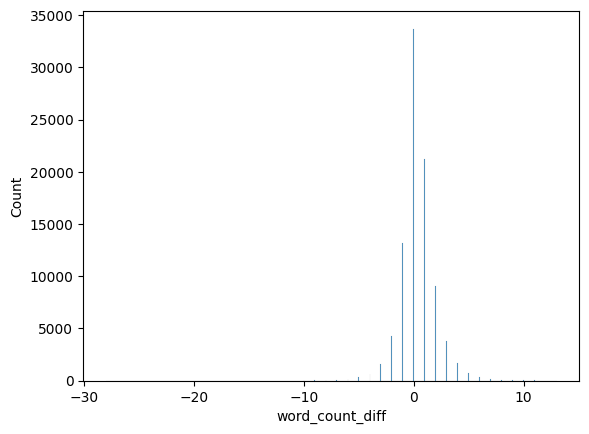

In [58]:
# visualise the histogram for word count difference (word_count_corrected_fs minus word_count_original)
sns.histplot(data=df_cor_eda,x='word_count_diff')

In [59]:
# display the top 10 rows with largest word count difference
df_cor_eda.sort_values(by=['word_count_diff'],ascending=False).head(10) #.style.set_properties(subset=['original'], **{'width': '400px'})

,original,word_count_original,corrected_fs,word_count_corrected_fs,word_count_diff,word_count_ratio
29607,At the beginning I just didnt want to give up ...,27,"At the beginning, I just didnt want to give up...",40,13,1.481481
48311,"It's sunday,it's hard to see in northeastern o...",34,"It's Sunday, and it's hard to see in northeast...",46,12,1.352941
20744,"Secondly, I do not strive for this test wholeh...",25,"Secondly, I did not strive to do my wholeheart...",37,12,1.480000
78624,I don't have a lover now However I believe in ...,31,I don't have a boyfriend now However I still b...,43,12,1.387097
22215,"And I hope one year from now, my English abili...",27,And I hope (that) one year from now [[or next ...,39,12,1.444444
93228,It is not until the individuals gain a higher ...,30,It is not until the individuals gain a higher ...,42,12,1.400000
3052,"Today,when i login the facebook,i find a websi...",34,"Today, when I logged into facebook, I found a ...",46,12,1.352941
49515,"However, personally I believe that the hard co...",36,"However, I personally believe that the tough c...",47,11,1.305556
75878,Because of the man put the woman out of busine...,39,Because of the man put the woman out of busine...,50,11,1.282051
59134,Because the students have not studied English ...,32,The students have not studied English well in ...,43,11,1.343750


<Axes: xlabel='word_count_ratio', ylabel='Count'>

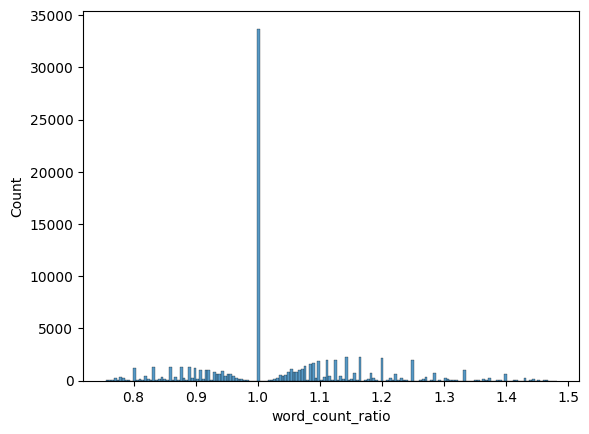

In [60]:
# visualise the histogram for word count ratio (word_count_corrected_fs:word_count_original)
sns.histplot(data=df_cor_eda,x='word_count_ratio')

In [61]:
# save csv file
file_path=os.path.join(parent_folder, '2. Raw Data/Japanese_to_English_cleaned.csv')
df_cor_eda.to_csv(file_path)

### Word Counts by POS Tags

In [62]:
# create the pos tags for original sentences and name the column 'o_pos_tags'
df_cor_eda['o_pos_tags']=df_cor_eda['original'].apply(lambda x: nltk.pos_tag(word_tokenize(x)))

In [63]:
# count the number of verb, noun, adjective, adverb, pronoun, preposition, conjection, article, modal in original sentences
df_cor_eda['o_num_verbs'] = df_cor_eda['o_pos_tags'].apply(lambda x: len([word for word, pos in x if pos.startswith('V')]))
df_cor_eda['o_num_nouns'] = df_cor_eda['o_pos_tags'].apply(lambda x: len([word for word, pos in x if pos.startswith('N')]))
df_cor_eda['o_num_adjs'] = df_cor_eda['o_pos_tags'].apply(lambda x: len([word for word, pos in x if pos.startswith('J')]))
df_cor_eda['o_num_adv'] = df_cor_eda['o_pos_tags'].apply(lambda x: len([word for word, pos in x if pos.startswith('RB')]))
df_cor_eda['o_num_pronoun'] = df_cor_eda['o_pos_tags'].apply(lambda x: len([word for word, pos in x if pos.startswith('PRP')]))
df_cor_eda['o_num_preposition'] = df_cor_eda['o_pos_tags'].apply(lambda x: len([word for word, pos in x if pos.startswith('IN')]))
df_cor_eda['o_num_conjunction'] = df_cor_eda['o_pos_tags'].apply(lambda x: len([word for word, pos in x if pos.startswith('CC')]))
df_cor_eda['o_num_article'] = df_cor_eda['o_pos_tags'].apply(lambda x: len([word for word, pos in x if pos.startswith('DT')]))
df_cor_eda['o_num_modal'] = df_cor_eda['o_pos_tags'].apply(lambda x: len([word for word, pos in x if pos.startswith('MD')]))

In [64]:
# create the pos tags for corrected sentences and name the column 'c_pos_tags'
df_cor_eda['c_pos_tags']=df_cor_eda['corrected_fs'].apply(lambda x: nltk.pos_tag(word_tokenize(x)))

In [65]:
# count the number of verb, noun, adjective, adverb, pronoun, preposition, conjection, article, modal in corrected sentences
df_cor_eda['c_num_verbs'] = df_cor_eda['c_pos_tags'].apply(lambda x: len([word for word, pos in x if pos.startswith('V')]))
df_cor_eda['c_num_nouns'] = df_cor_eda['c_pos_tags'].apply(lambda x: len([word for word, pos in x if pos.startswith('N')]))
df_cor_eda['c_num_adjs'] = df_cor_eda['c_pos_tags'].apply(lambda x: len([word for word, pos in x if pos.startswith('J')]))
df_cor_eda['c_num_adv'] = df_cor_eda['c_pos_tags'].apply(lambda x: len([word for word, pos in x if pos.startswith('RB')]))
df_cor_eda['c_num_pronoun'] = df_cor_eda['c_pos_tags'].apply(lambda x: len([word for word, pos in x if pos.startswith('PRP')]))
df_cor_eda['c_num_preposition'] = df_cor_eda['c_pos_tags'].apply(lambda x: len([word for word, pos in x if pos.startswith('IN')]))
df_cor_eda['c_num_conjunction'] = df_cor_eda['c_pos_tags'].apply(lambda x: len([word for word, pos in x if pos.startswith('CC')]))
df_cor_eda['c_num_article'] = df_cor_eda['c_pos_tags'].apply(lambda x: len([word for word, pos in x if pos.startswith('DT')]))
df_cor_eda['c_num_modal'] = df_cor_eda['c_pos_tags'].apply(lambda x: len([word for word, pos in x if pos.startswith('MD')]))

In [66]:
# count the differences for number of verb, noun, adjective, adverb, pronoun, preposition, conjection, article, modal between corrected and original sentences
df_cor_eda['num_verbs_diff'] = df_cor_eda['c_num_verbs'] - df_cor_eda['o_num_verbs']
df_cor_eda['num_nouns_diff'] = df_cor_eda['c_num_nouns'] - df_cor_eda['o_num_nouns']
df_cor_eda['num_adjs_diff'] = df_cor_eda['c_num_adjs'] - df_cor_eda['o_num_adjs']
df_cor_eda['num_adv_diff'] = df_cor_eda['c_num_adv'] - df_cor_eda['o_num_adv']
df_cor_eda['num_pronoun_diff'] = df_cor_eda['c_num_pronoun'] - df_cor_eda['o_num_pronoun']
df_cor_eda['num_preposition_diff'] = df_cor_eda['c_num_preposition'] - df_cor_eda['o_num_preposition']
df_cor_eda['num_conjunction_diff'] = df_cor_eda['c_num_conjunction'] - df_cor_eda['o_num_conjunction']
df_cor_eda['num_article_diff'] = df_cor_eda['c_num_article'] - df_cor_eda['o_num_article']
df_cor_eda['num_modal_diff'] = df_cor_eda['c_num_modal'] - df_cor_eda['o_num_modal']

<Axes: xlabel='num_verbs_diff', ylabel='Count'>

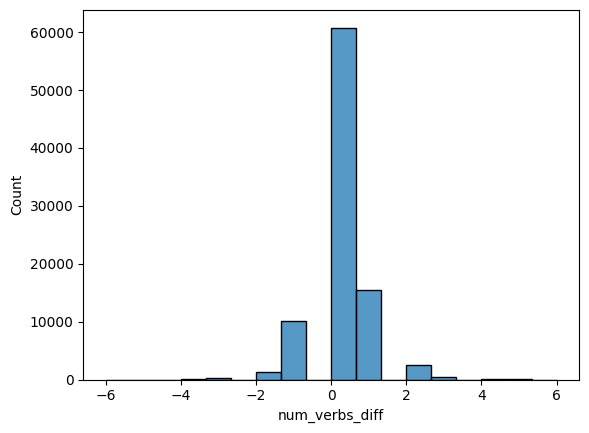

In [67]:
# visualise the histogram for num_verbs_diff
sns.histplot(data=df_cor_eda,x='num_verbs_diff')

<Axes: xlabel='num_nouns_diff', ylabel='Count'>

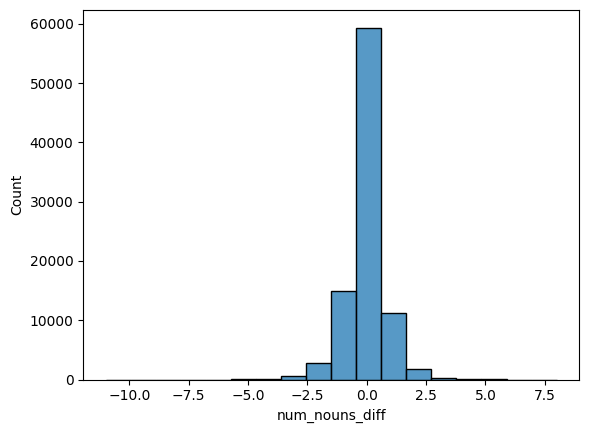

In [68]:
# visualise the histogram for num_nouns_diff
sns.histplot(data=df_cor_eda,x='num_nouns_diff')

<Axes: xlabel='num_adjs_diff', ylabel='Count'>

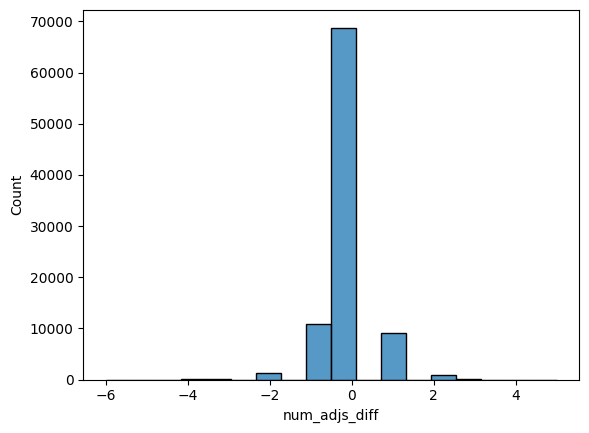

In [69]:
# visualise the histogram for num_adjs_diff
sns.histplot(data=df_cor_eda,x='num_adjs_diff')

<Axes: xlabel='num_adv_diff', ylabel='Count'>

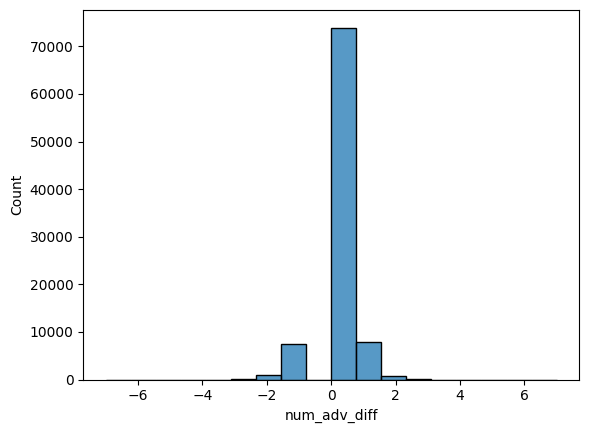

In [70]:
# visualise the histogram for num_adv_diff
sns.histplot(data=df_cor_eda,x='num_adv_diff')

<Axes: xlabel='num_pronoun_diff', ylabel='Count'>

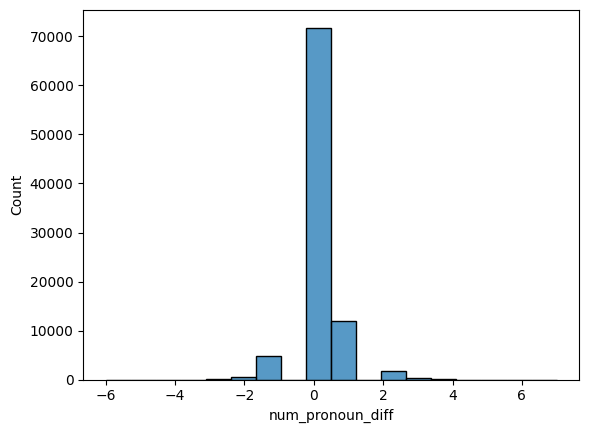

In [71]:
# visualise the histogram for num_pronoun_diff
sns.histplot(data=df_cor_eda,x='num_pronoun_diff')

<Axes: xlabel='num_conjunction_diff', ylabel='Count'>

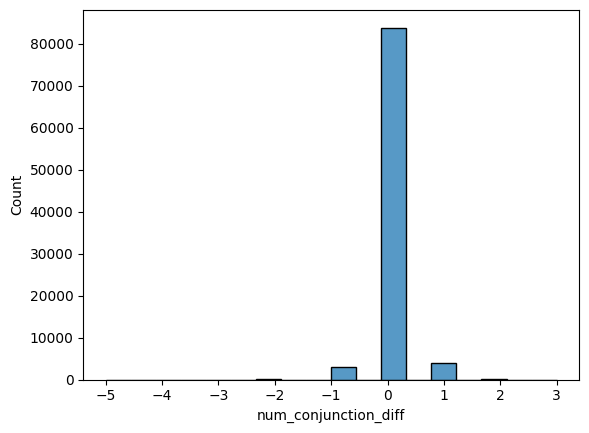

In [72]:
# visualise the histogram for num_conjunction_diff
sns.histplot(data=df_cor_eda,x='num_conjunction_diff')

<Axes: xlabel='num_article_diff', ylabel='Count'>

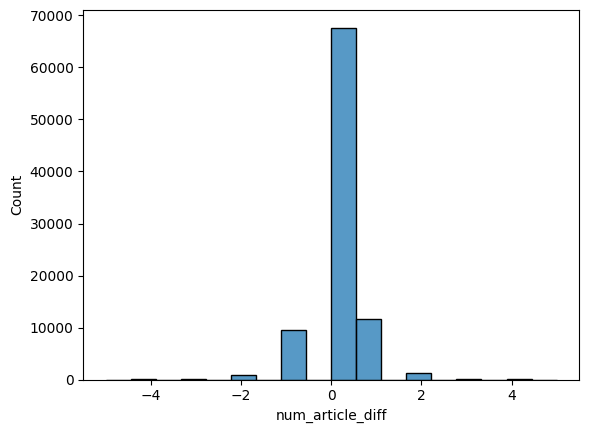

In [73]:
# visualise the histogram for num_article_diff
sns.histplot(data=df_cor_eda,x='num_article_diff')

<Axes: xlabel='num_modal_diff', ylabel='Count'>

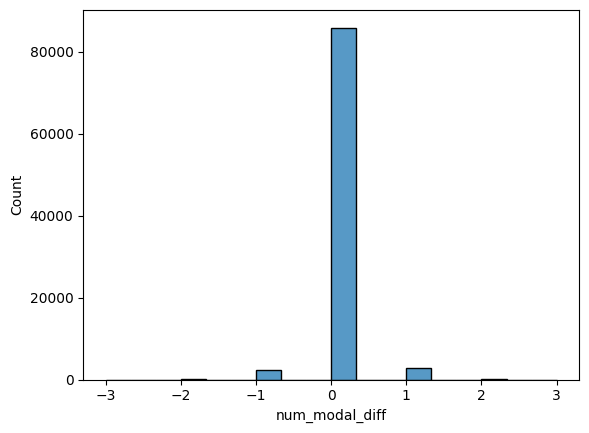

In [74]:
# visualise the histogram for num_modal_diff
sns.histplot(data=df_cor_eda,x='num_modal_diff')

In [75]:
# save csv file
file_path=os.path.join(parent_folder, '2. Raw Data/Japanese_to_English_pos.csv')
df_cor_eda.to_csv(file_path)